## Evaluation of the trained fomo models on HC dataset

In [1]:
import pandas as pd
import yaml
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

import model_loss as ml
from DatasetLoader import DatasetLoader as dl

### First, read the results file for performance results of each model

In [2]:
yaml_file_path = "results_m.yaml"
with open(yaml_file_path, "r") as f:
    loaded_yaml = yaml.safe_load(f)

In [3]:
records = []
for key, value_list in loaded_yaml.items():
    parts = key.split("_")
    alpha = parts[2]
    resolution = parts[3]
    loss = value_list.get("loss")
    
    res = f'{resolution.replace("r", "")} x {resolution.replace("r", "")} x 3'

    record = {
        "alpha": alpha.replace("a0", "0."),
        "resolution": res,
        "loss": loss,
        "name": key
    }
    records.append(record)

print(records)
df = pd.DataFrame(records)


[{'alpha': '0.35', 'resolution': '96 x 96 x 3', 'loss': 0.16681347787380219, 'name': 'out_m/fomo_a035_r96_0'}, {'alpha': '0.35', 'resolution': '128 x 128 x 3', 'loss': 0.11190354824066162, 'name': 'out_m/fomo_a035_r128_0'}, {'alpha': '0.35', 'resolution': '224 x 224 x 3', 'loss': 0.05104606971144676, 'name': 'out_m/fomo_a035_r224_0'}, {'alpha': '0.75', 'resolution': '96 x 96 x 3', 'loss': 0.1521058827638626, 'name': 'out_m/fomo_a075_r96_0'}, {'alpha': '0.75', 'resolution': '128 x 128 x 3', 'loss': 0.09264899790287018, 'name': 'out_m/fomo_a075_r128_0'}, {'alpha': '0.75', 'resolution': '224 x 224 x 3', 'loss': 0.04291384294629097, 'name': 'out_m/fomo_a075_r224_0'}, {'alpha': '0.35', 'resolution': '96 x 96 x 3', 'loss': 0.15043392777442932, 'name': 'out_m/fomo_a035_r96_1'}, {'alpha': '0.35', 'resolution': '128 x 128 x 3', 'loss': 0.10470280051231384, 'name': 'out_m/fomo_a035_r128_1'}, {'alpha': '0.35', 'resolution': '224 x 224 x 3', 'loss': 0.04604019224643707, 'name': 'out_m/fomo_a035_r2

### Create a plot and table out of it

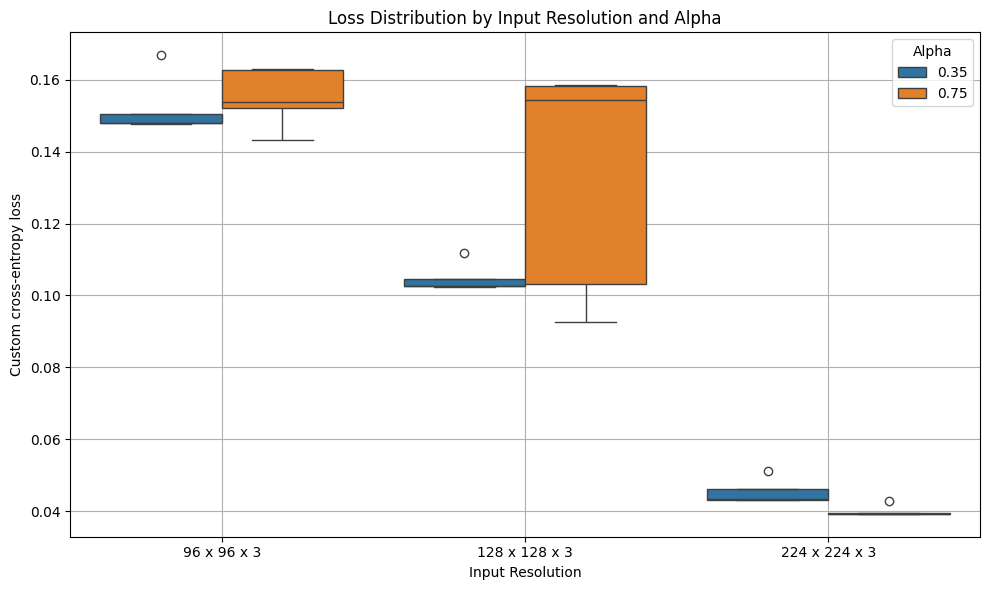

In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="resolution", y="loss", hue="alpha")
plt.title("Loss Distribution by Input Resolution and Alpha")
plt.xlabel("Input Resolution")
plt.ylabel("Custom cross-entropy loss")
plt.legend(title="Alpha")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
loss_summary = df.groupby(['resolution', 'alpha'])['loss'].agg(['median', 'min', 'max']).reset_index()
summary_pivot = loss_summary.pivot(index='resolution', columns='alpha', values=['median', 'min', 'max'])
summary_pivot = summary_pivot.round(4)

summary_pivot

median             min             max        
alpha            0.35    0.75    0.35    0.75    0.35    0.75
resolution                                                   
128 x 128 x 3  0.1027  0.1544  0.1024  0.0926  0.1119  0.1584
224 x 224 x 3  0.0433  0.0393  0.0431  0.0393  0.0510  0.0429
96 x 96 x 3    0.1479  0.1539  0.1478  0.1433  0.1668  0.1629

In [6]:
# Find the median validation loss for each (resolution, alpha) combination
median_losses = df.groupby(['resolution', 'alpha'])['loss'].median().reset_index()
median_losses.rename(columns={'loss': 'median_val_loss'}, inplace=True)

# Merge back to original DataFrame to find rows that match the median
merged = pd.merge(df, median_losses, on=['resolution', 'alpha'])

# Filter to only rows where val_loss matches the median
median_models = merged[merged['loss'] == merged['median_val_loss']][['resolution', 'alpha', 'name', 'loss']]

# Display the resulting model names with their median loss
median_models.sort_values(by=['resolution', 'alpha'])

lijst = median_models.name.to_list()
lijst

['out_m/fomo_a035_r128_2',
 'out_m/fomo_a035_r224_2',
 'out_m/fomo_a075_r96_2',
 'out_m/fomo_a075_r128_2',
 'out_m/fomo_a035_r96_3',
 'out_m/fomo_a075_r224_3']

### Calculate for each model the MAE

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf

def evaluate_mae(model, image_paths, count_csv_path, res, get_sample_fn, threshold=0.5):
    # Load ground truth counts
    gt_df = pd.read_csv(count_csv_path)
    gt_dict = dict(zip(gt_df['filename'], gt_df['count']))

    abs_errors = []

    for img_path in image_paths:
        filename = os.path.basename(img_path)
        gt_count = gt_dict.get(filename, None)

        if gt_count is None:
            print(f"Warning: No ground truth for {filename}")
            continue

        image_tensor = get_sample_fn(img_path, res)
        image_tensor = tf.expand_dims(image_tensor, axis=0)  # add batch dim

        preds = model.predict(image_tensor)

        heatmap = preds[0, :, :, 0]
        pred_count = np.sum(heatmap > threshold)  

        abs_errors.append(abs(gt_count - pred_count))

    mae = np.mean(abs_errors)
    print(f"MAE: {mae:.4f}")
    return mae

In [8]:
def get_sample_fomo(path, res):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, (res, res))
    image = tf.cast(image, tf.float32) / 255.0

    return image

In [9]:
# model to mae:
results = dict()

IMG_PATH = "../../dataset/hc/val/images"
CSV_PATH = "../../dataset/hc/val/count.csv"

for i in lijst:
    print(i)
    res = int(re.search("_r\d*", i).group(0).replace("_r", ""))

    model_to_eval = tf.keras.models.load_model(f"{i}.keras", compile=True, custom_objects={'weighted_xent': ml.construct_weighted_xent_fn((1, res // 8, res // 8, 2), object_weight=100)})
    image_paths = list(map(lambda x: os.path.join(IMG_PATH, x), os.listdir(IMG_PATH)))
    mae = evaluate_mae(model_to_eval, image_paths, CSV_PATH, res=res, get_sample_fn=get_sample_fomo, threshold=0.5)

    results[i] = mae

out_m/fomo_a035_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [10]:
results

{'out_m/fomo_a035_r128_2': np.float64(3.2427184466019416),
 'out_m/fomo_a035_r224_2': np.float64(5.524271844660194),
 'out_m/fomo_a075_r96_2': np.float64(1.6893203883495145),
 'out_m/fomo_a075_r128_2': np.float64(1.7087378640776698),
 'out_m/fomo_a035_r96_3': np.float64(2.3883495145631066),
 'out_m/fomo_a075_r224_3': np.float64(3.883495145631068)}

same mae for two models? see if there is an example where the count differs

In [11]:
sample = image_paths[2]               # any image
for model_path in ['out_m/fomo_a075_r96_2.keras', 'out_m/fomo_a075_r128_2.keras']:
    model = tf.keras.models.load_model(model_path, compile=False)
    img   = get_sample_fomo(sample, res=96 if "r96" in model_path else 128)
    pred  = model.predict(img[None, ...])[0, :, :, 0]   # person channel
    print(model_path, "count =", (pred > 0.5).sum())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
out_m/fomo_a075_r96_2.keras count = 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
out_m/fomo_a075_r128_2.keras count = 13


### Now Let's visualize some examples

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def get_img_array(path, res):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, (res, res))
    casted = tf.cast(image, tf.float32) / 255.0

    array = tf.keras.utils.img_to_array(casted)
    array = np.expand_dims(array, axis=0)

    return array, image

def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

In [13]:
import cv2

def calculate_count(score_map, threshold):
    count = 0
    grid_h, grid_w = score_map.shape
    for y in range(grid_h):
        for x in range(grid_w):
            score = score_map[y, x]
            if score > threshold:
                count += 1
    return count

def plot_fomo_output(img, out, class_index=0, threshold=0.7, show_centers=False, heatmap_clip_threshold=0.3, show = True):

    # Remove batch dims
    if img.ndim == 4:
        img = img[0]
    if out.ndim == 4:
        out = out[0]

    # Convert logits to probabilities
    probs = 1 / (1 + np.exp(-out))  # sigmoid

    # Extract class-specific score map
    score_map = probs[..., class_index]

    # Resize heatmap to input image size
    heatmap_resized = cv2.resize(score_map, (img.shape[1], img.shape[0]))

    # Mask out low-probability areas
    heatmap_masked = np.where(heatmap_resized >= heatmap_clip_threshold, heatmap_resized, 0)

    # Normalize for color map
    heatmap_norm = cv2.normalize(heatmap_masked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

    # Prepare base image
    img_uint8 = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
    blended = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    # Optionally show detection centers
    if show_centers:
        grid_h, grid_w = score_map.shape
        stride_x = img.shape[1] / grid_w
        stride_y = img.shape[0] / grid_h

        for y in range(grid_h):
            for x in range(grid_w):
                score = score_map[y, x]
                if score > threshold:
                    cx = int((x + 0.5) * stride_x)
                    cy = int((y + 0.5) * stride_y)
                    cv2.circle(blended, (cx, cy), 3, (255, 255, 255), -1)

    # Plot final image
    if show:
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('FOMO Output')
        plt.show()
    else:
        return cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)

#### Let's show some results for the different resolutions, with alpha = 0.35

out_m/fomo_a035_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
out_m/fomo_a035_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
out_m/fomo_a035_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
out_m/fomo_a035_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Images for fomo with a=0.35, res= 128


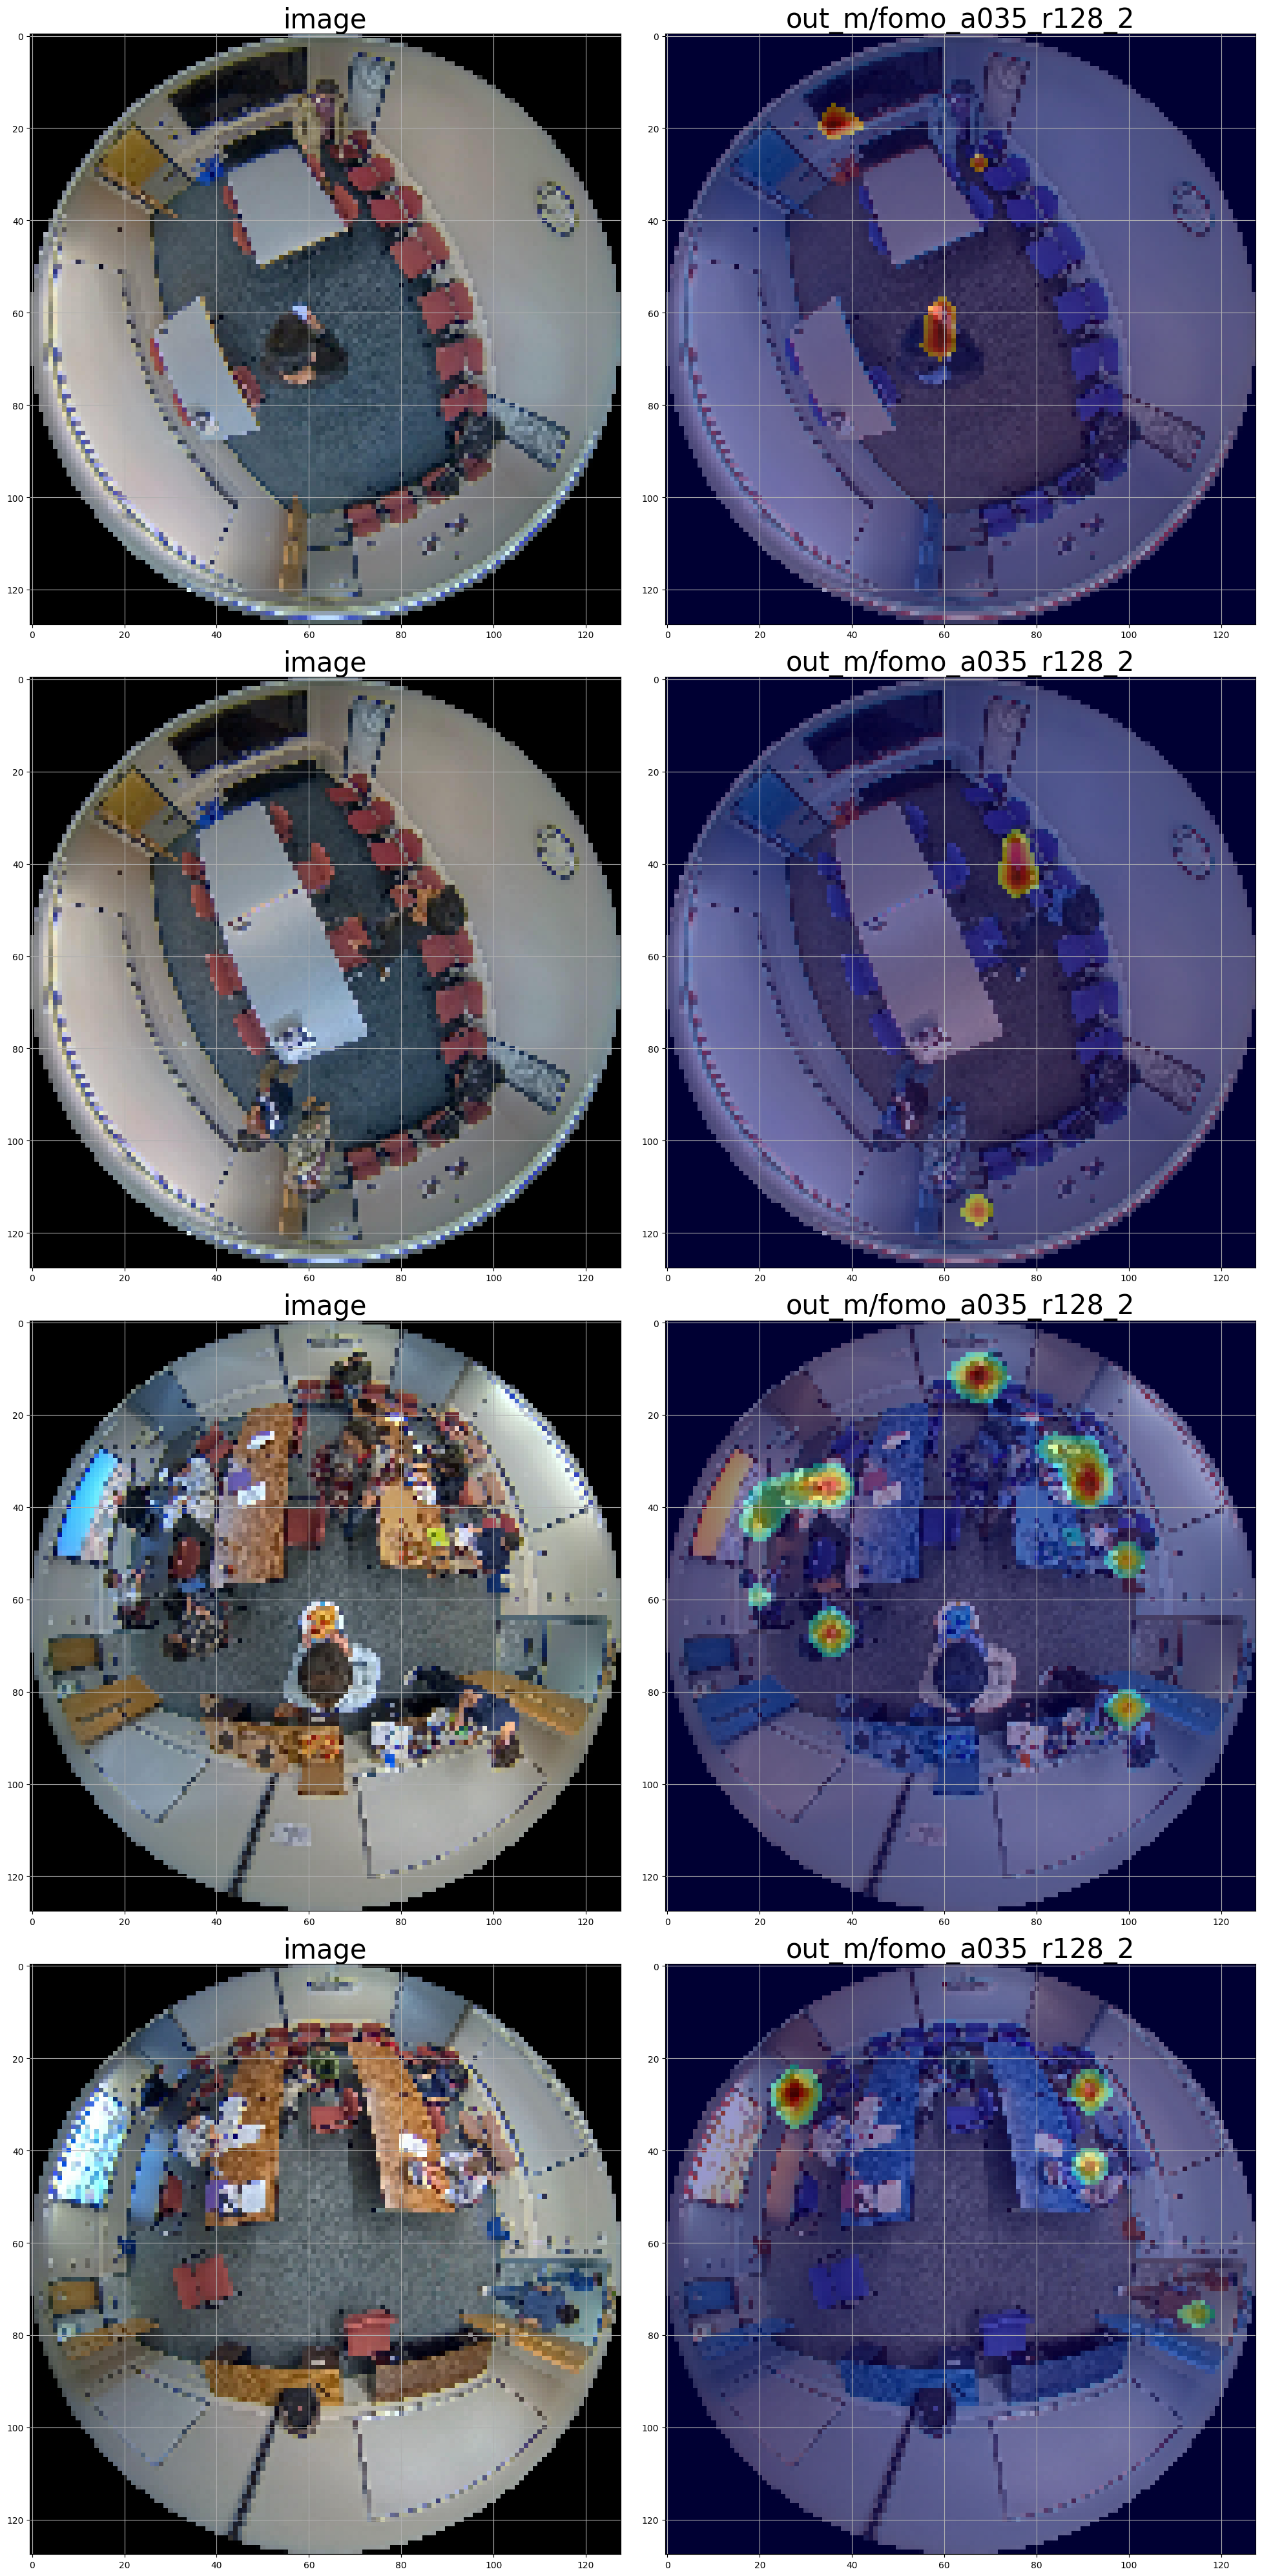

out_m/fomo_a035_r224_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
out_m/fomo_a035_r224_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
out_m/fomo_a035_r224_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
out_m/fomo_a035_r224_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Images for fomo with a=0.35, res= 224


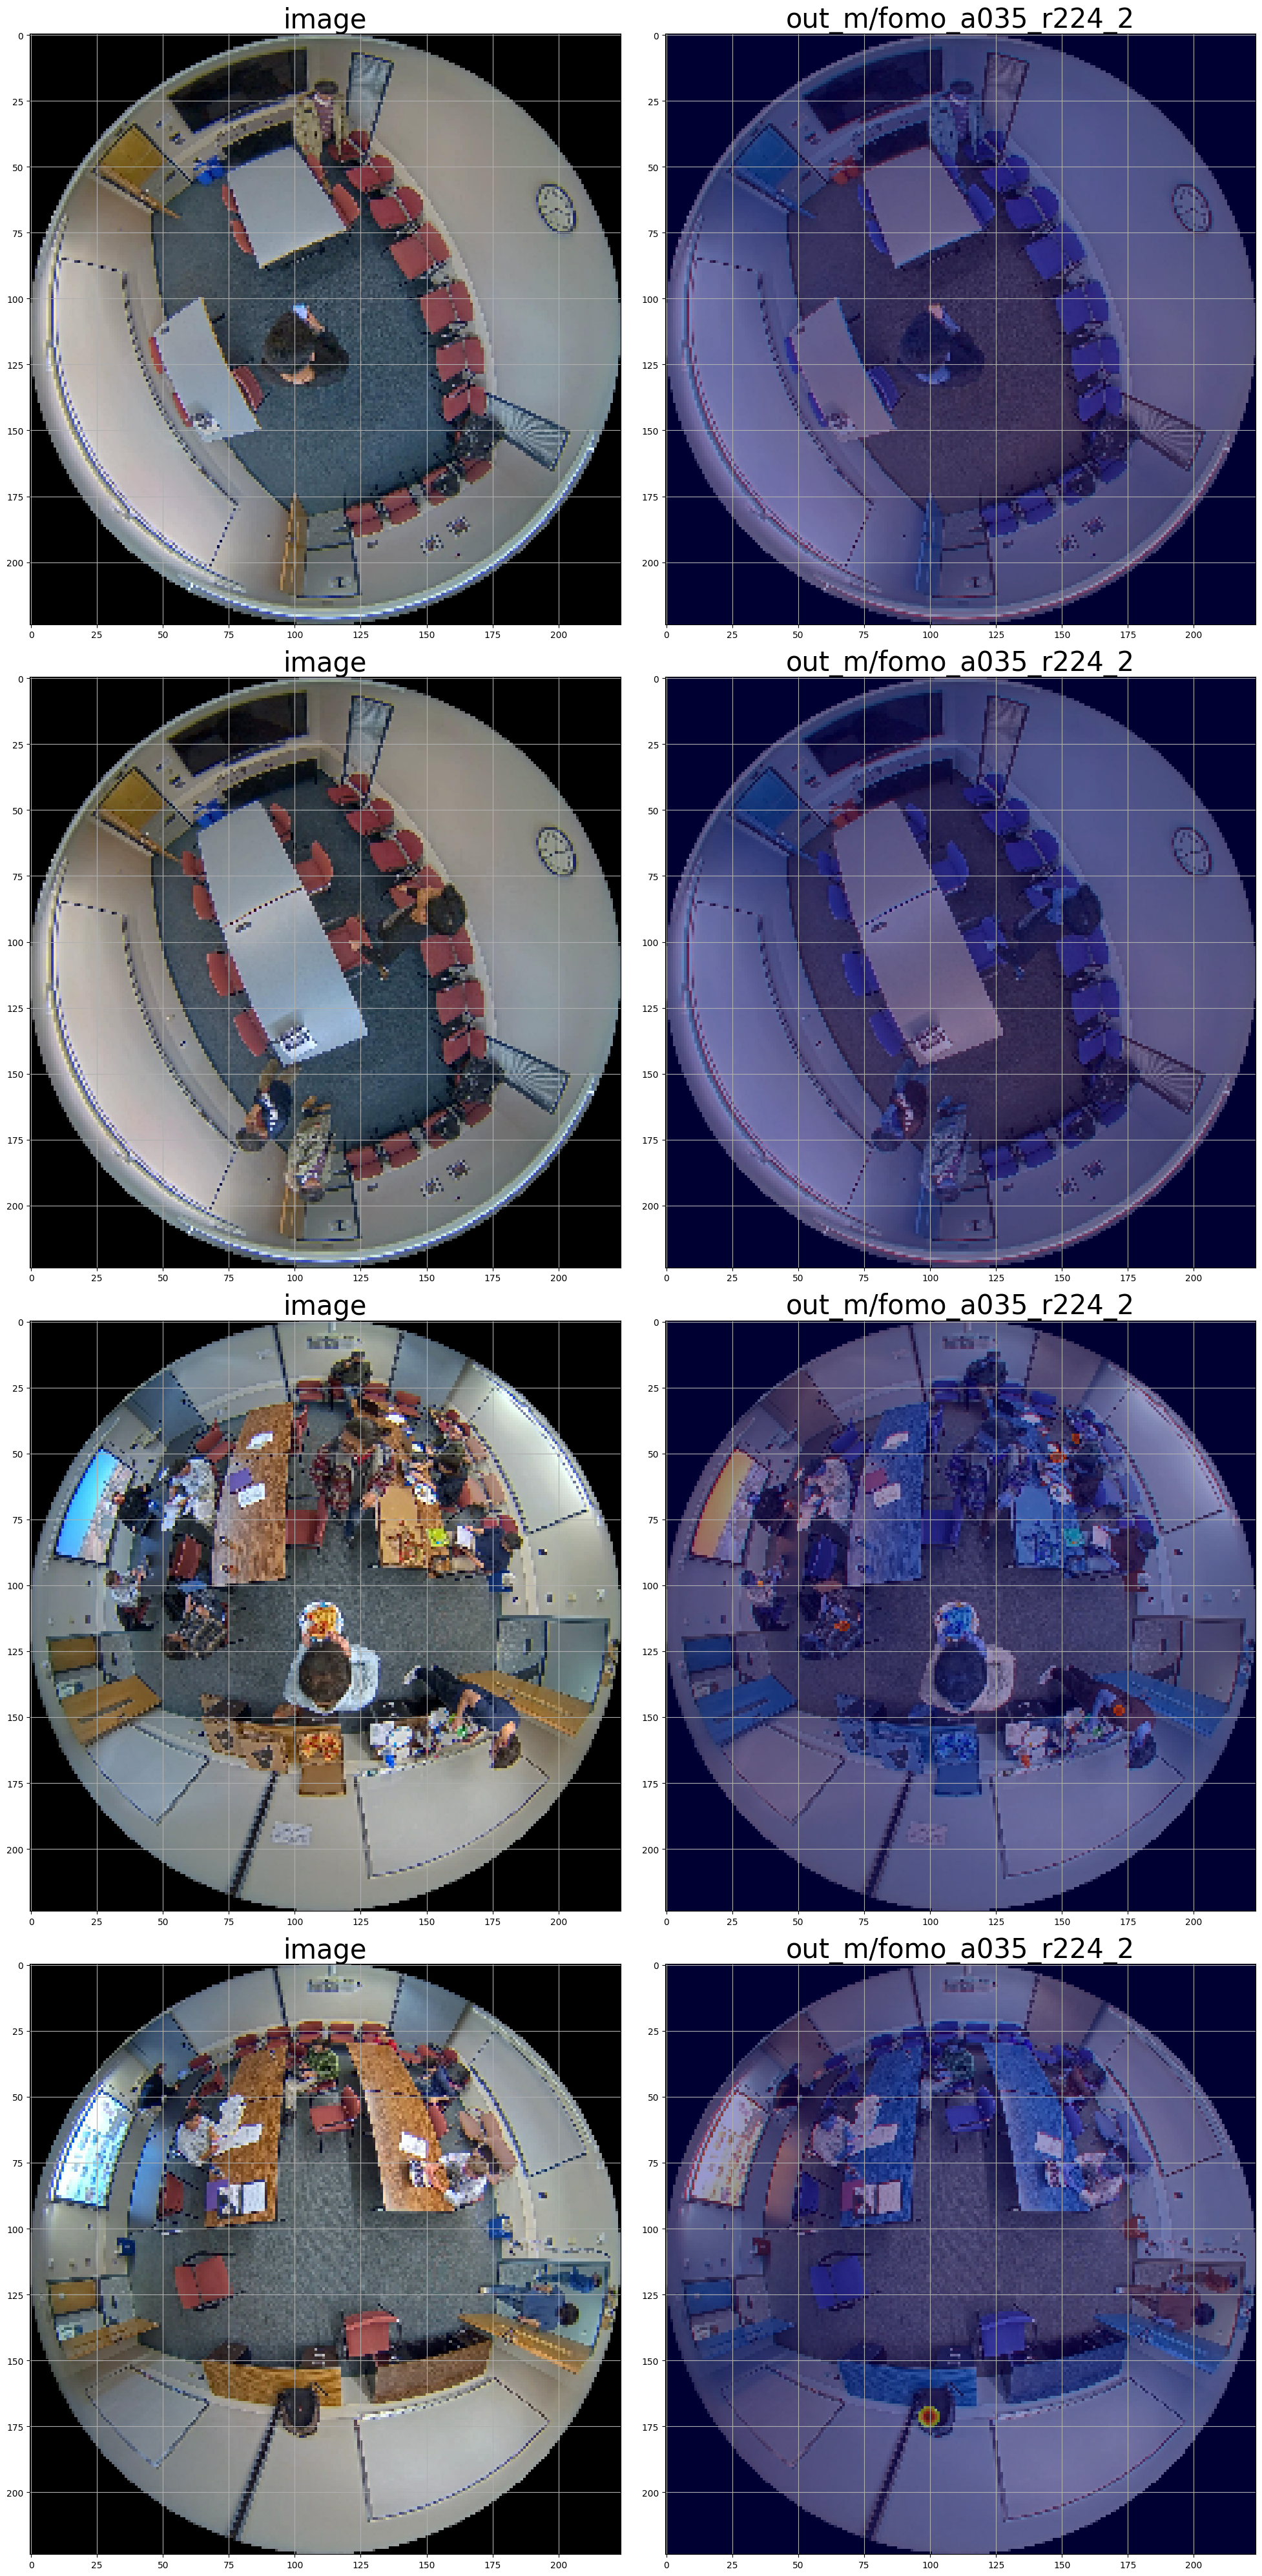

out_m/fomo_a035_r96_3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
out_m/fomo_a035_r96_3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
out_m/fomo_a035_r96_3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
out_m/fomo_a035_r96_3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Images for fomo with a=0.35, res= 96


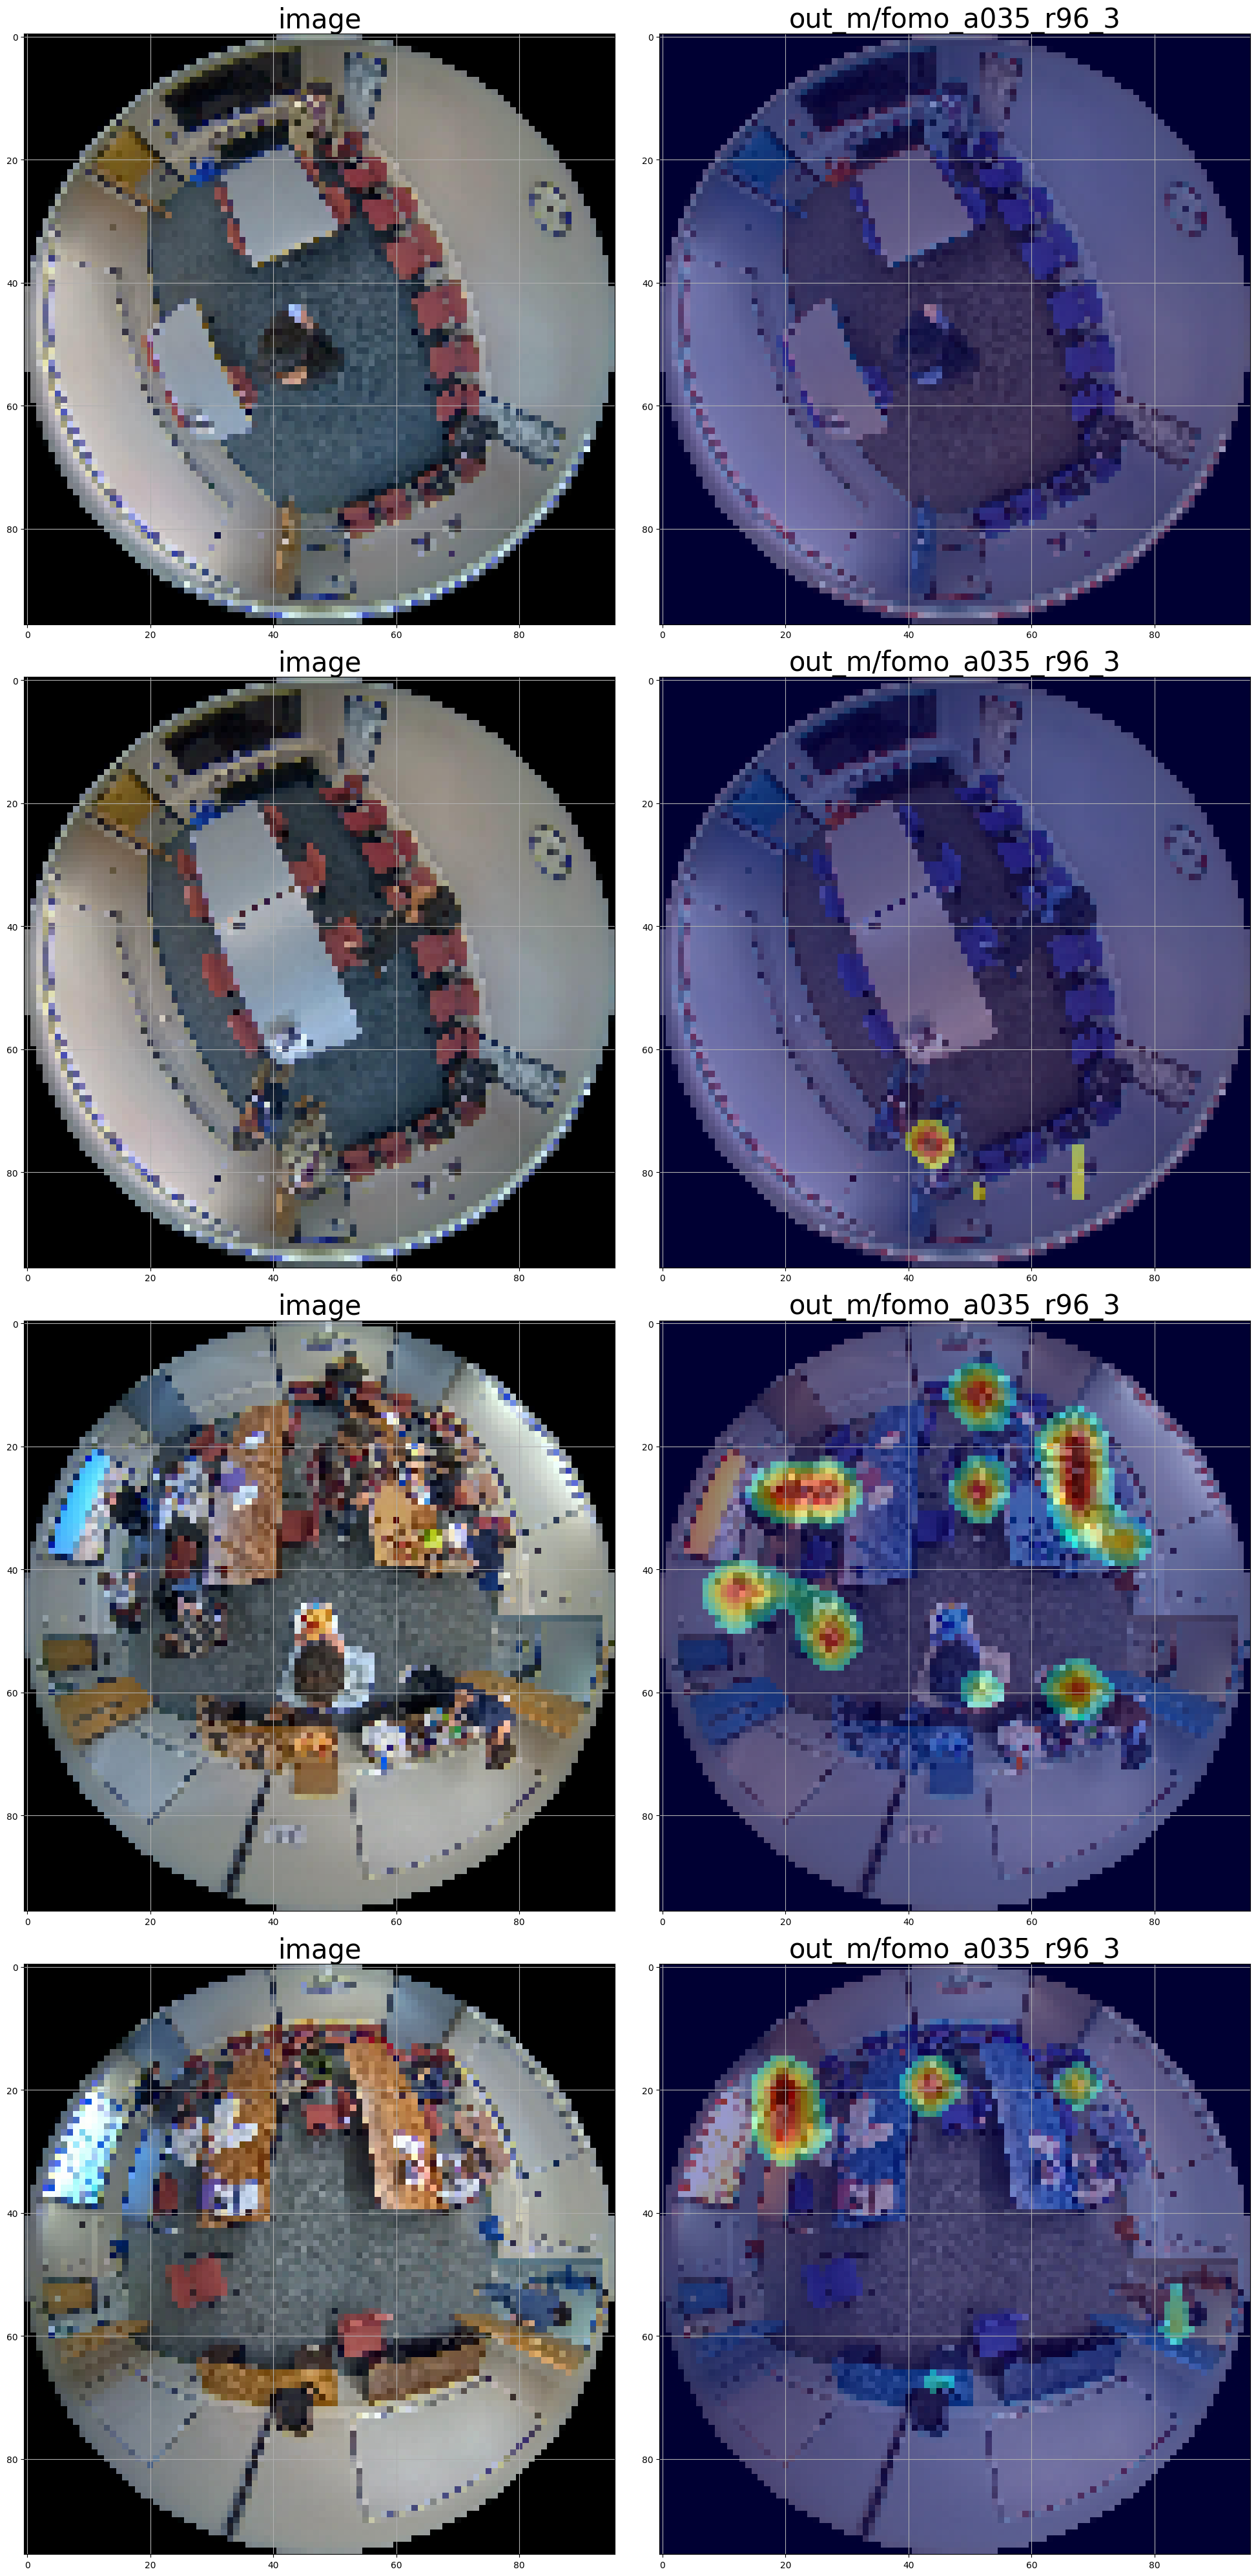

In [15]:
import re

images = ["../../dataset/hc/val/images/Meeting1_000201.jpg",
          "../../dataset/hc/val/images/Meeting2_000441.jpg",
          "../../dataset/hc/val/images/Lunch2_001441.jpg",
          "../../dataset/hc/val/images/Lunch3_000521.jpg",
          ]

for model_dir in lijst:
    if "a035" in model_dir:
        out= []
        out_names = []
        res = int(re.search("r\d*", model_dir).group(0).replace("r", ""))
        model = tf.keras.models.load_model(f"{model_dir}.keras", compile=True, custom_objects={'weighted_xent': ml.construct_weighted_xent_fn((1, res // 8, res // 8, 2), object_weight=100)})
        for img_path in images:
            arr, img = get_img_array(img_path, res)
            out.append(np.uint8(img))
            out_names.append("image")
            print(model_dir)
            out.append(np.uint8(plot_fomo_output(arr, model.predict(arr), show=False)))
            out_names.append(model_dir)

        print(f"Images for fomo with a=0.35, res= {res}")
        show_image_list(out, out_names, figsize=(20, 40))



Let's also visually compare the two models with the same mae

out_m/fomo_a075_r96_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
out_m/fomo_a075_r96_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
out_m/fomo_a075_r96_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
out_m/fomo_a075_r96_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Images for fomo with a=0.75, res= 96


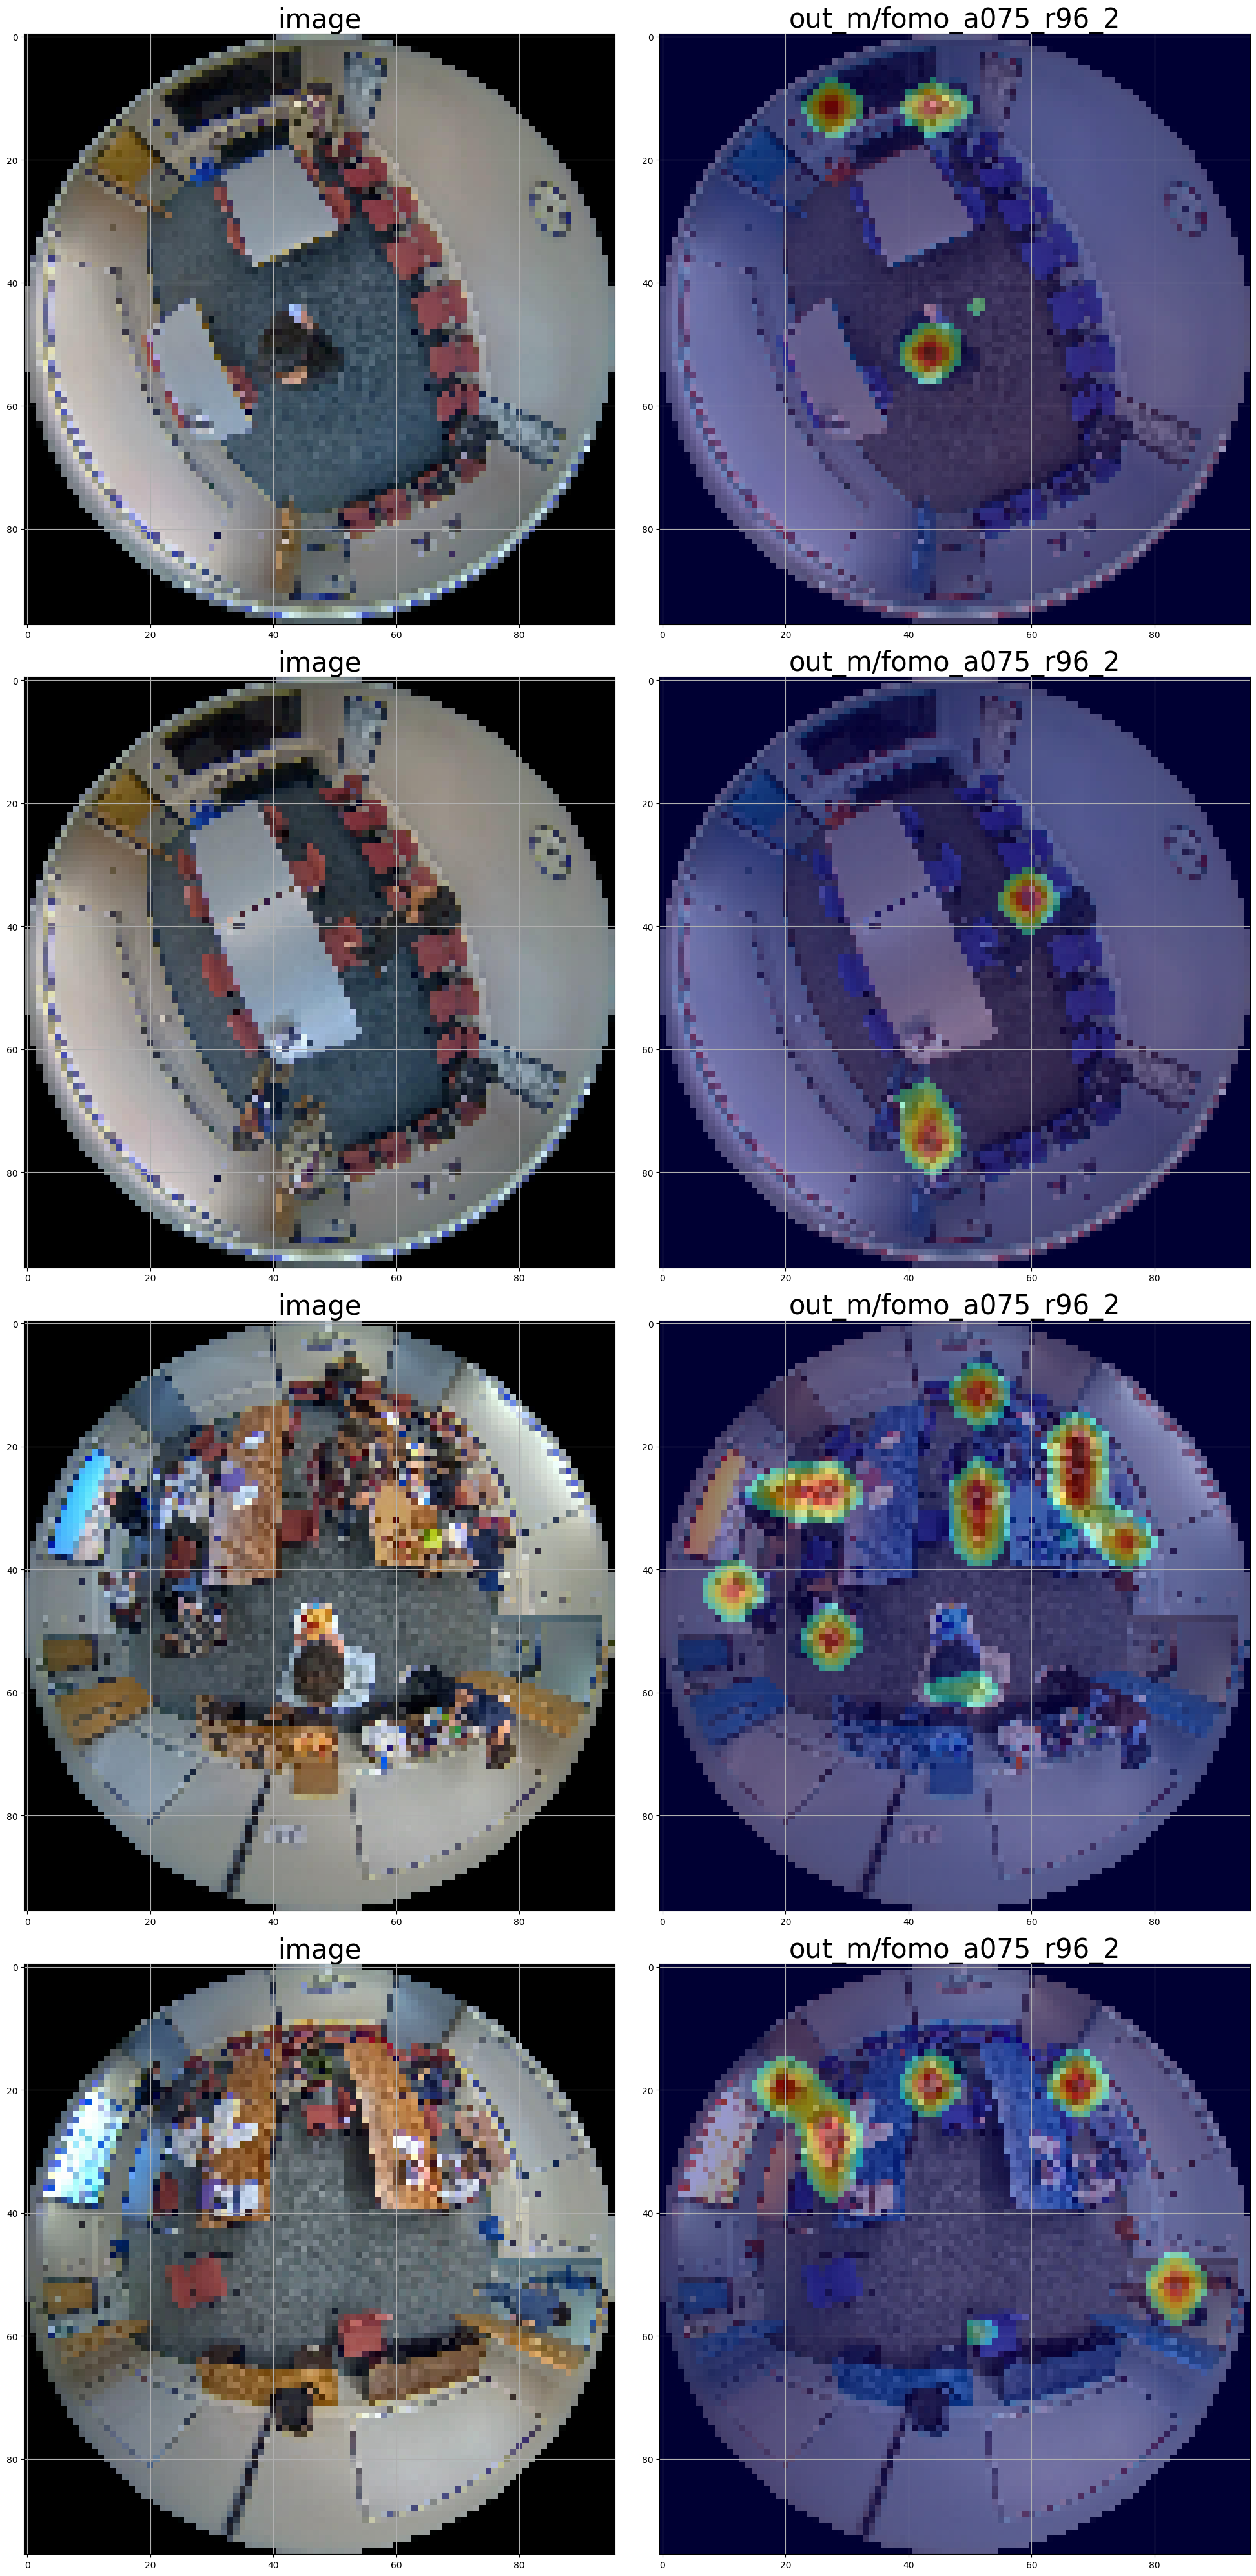

out_m/fomo_a075_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
out_m/fomo_a075_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
out_m/fomo_a075_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
out_m/fomo_a075_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Images for fomo with a=0.75, res= 128


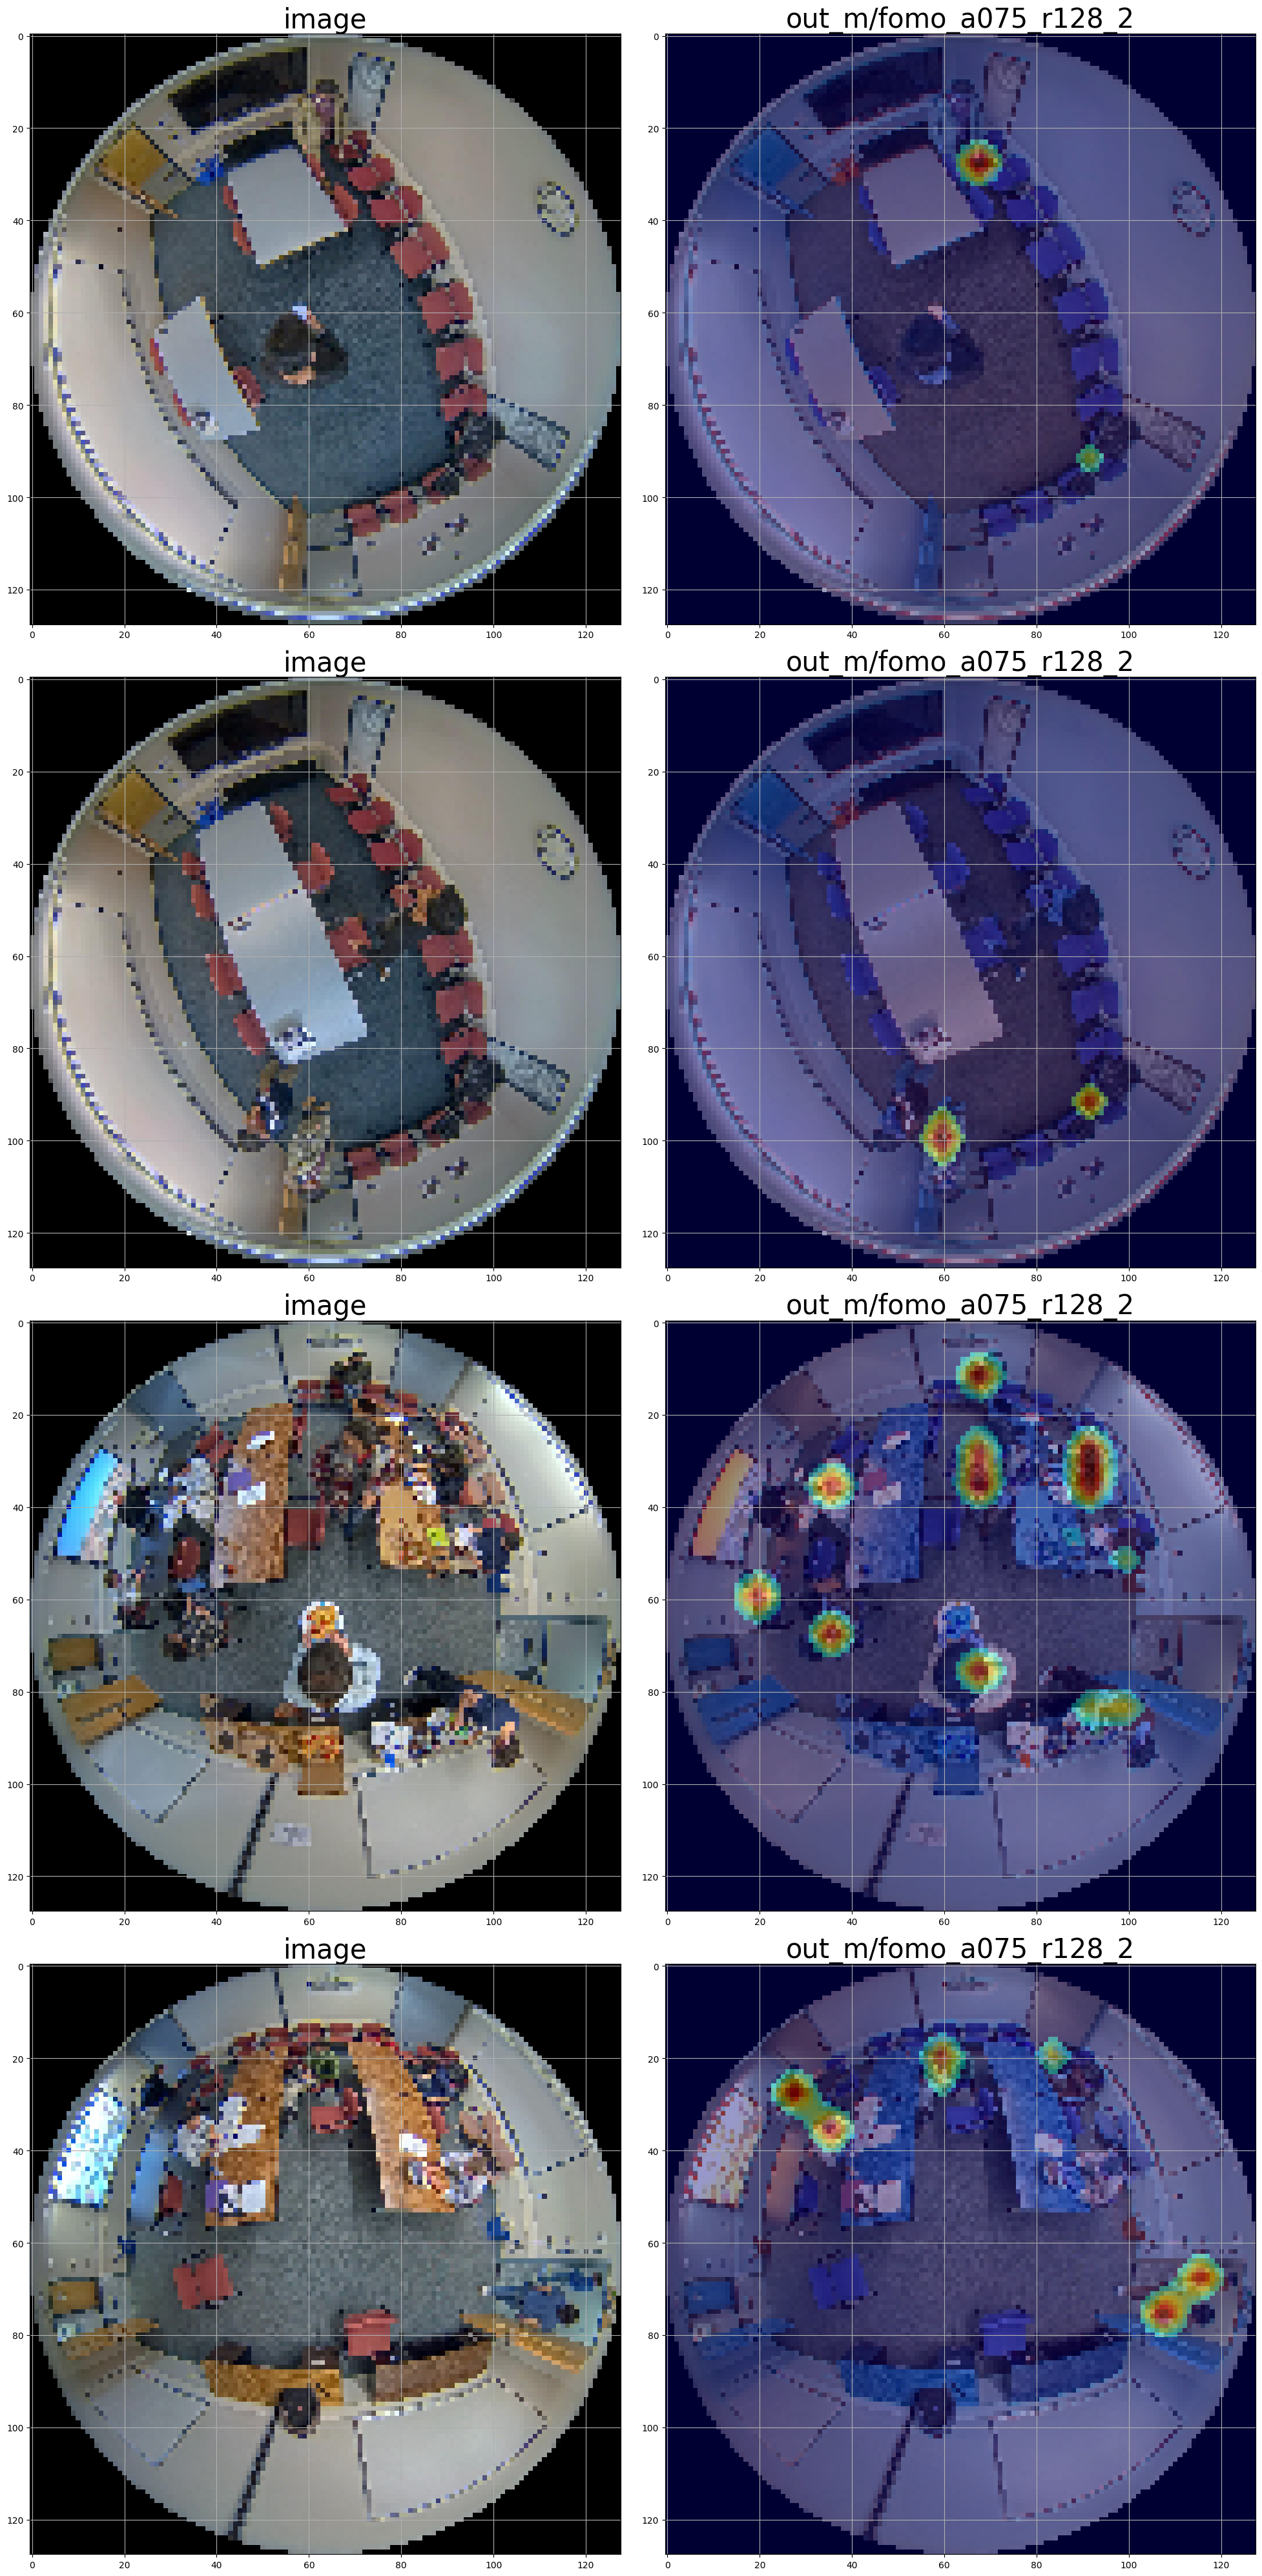

In [17]:
import re

for model_dir in ['out_m/fomo_a075_r96_2', 'out_m/fomo_a075_r128_2']:
    out= []
    out_names = []
    res = int(re.search("r\d*", model_dir).group(0).replace("r", ""))
    model = tf.keras.models.load_model(f"{model_dir}.keras", compile=True, custom_objects={'weighted_xent': ml.construct_weighted_xent_fn((1, res // 8, res // 8, 2), object_weight=100)})
    for img_path in images:
        arr, img = get_img_array(img_path, res)
        out.append(np.uint8(img))
        out_names.append("image")
        print(model_dir)
        out.append(np.uint8(plot_fomo_output(arr, model.predict(arr), show=False)))
        out_names.append(model_dir)
    print(f"Images for fomo with a=0.75, res= {res}")
    show_image_list(out, out_names, figsize=(20, 40))

### Now let's add some centerpoints and count them

In [18]:
def get_image_with_fomo_centers(image_path, annotation_path, res, point_color=(255, 255, 255), point_radius=4):
    """
    Loads an image and overlays center points from FOMO-style YOLO annotations.

    Parameters:
    - image_path: str, path to the image file
    - annotation_path: str, path to the .txt annotation file
    - point_color: tuple, BGR color for center points (default is red)
    - point_radius: int, radius of the drawn center points

    Returns:
    - image_with_points: np.ndarray, image with points drawn on it (uint8, BGR format)
    """
    # Load image using TensorFlow
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw, channels=3)
    image = tf.image.resize(image, (res, res))
    image_np = image.numpy()
    height, width = image_np.shape[:2]

    # Convert RGB (TensorFlow default) to BGR (OpenCV)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Read annotations
    with open(annotation_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 6:
                continue

            _, x_center, y_center, _, _, _ = map(float, parts)
            cx = int(x_center * width)
            cy = int(y_center * height)

            # Draw a filled circle at the center point
            cv2.circle(image_bgr, (cx, cy), point_radius, point_color, -1)

    return image_bgr

128
out_m/fomo_a035_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
out_m/fomo_a035_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
out_m/fomo_a035_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
out_m/fomo_a035_r128_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


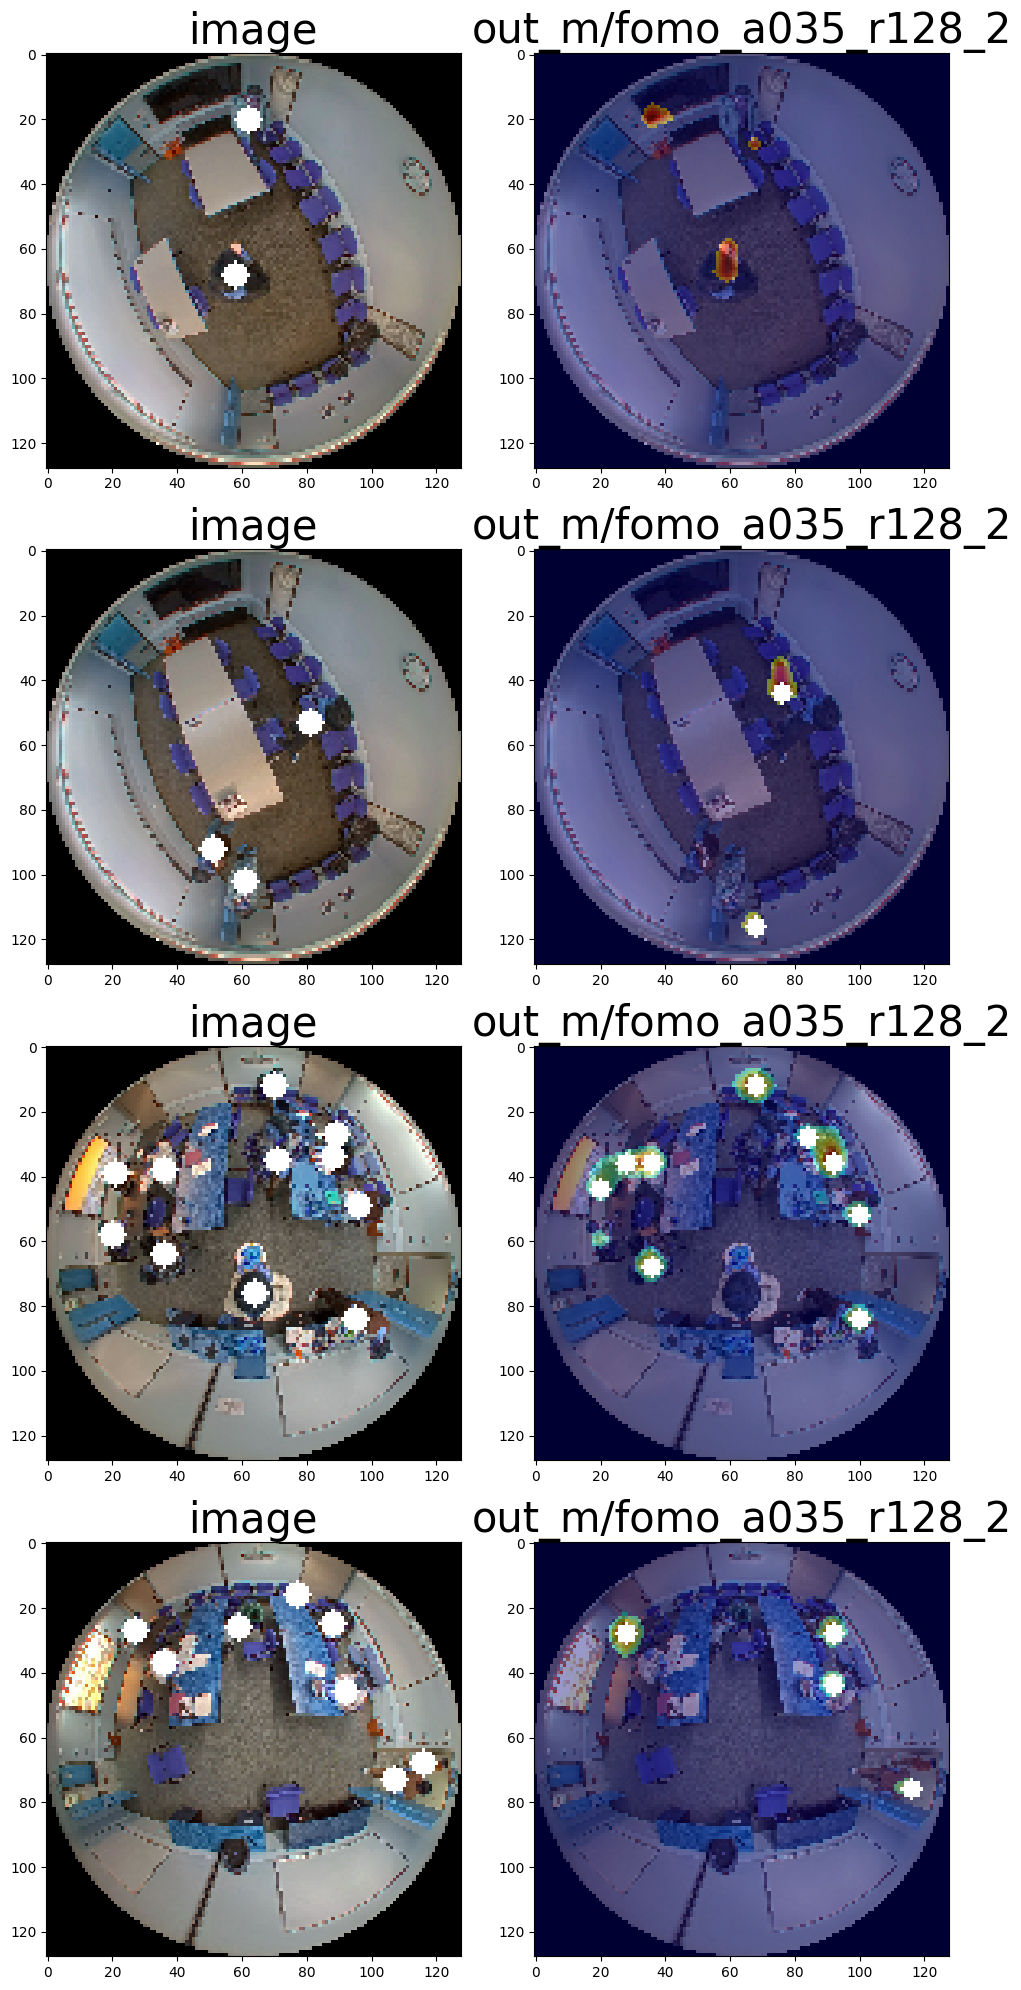

224
out_m/fomo_a035_r224_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
out_m/fomo_a035_r224_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
out_m/fomo_a035_r224_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
out_m/fomo_a035_r224_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


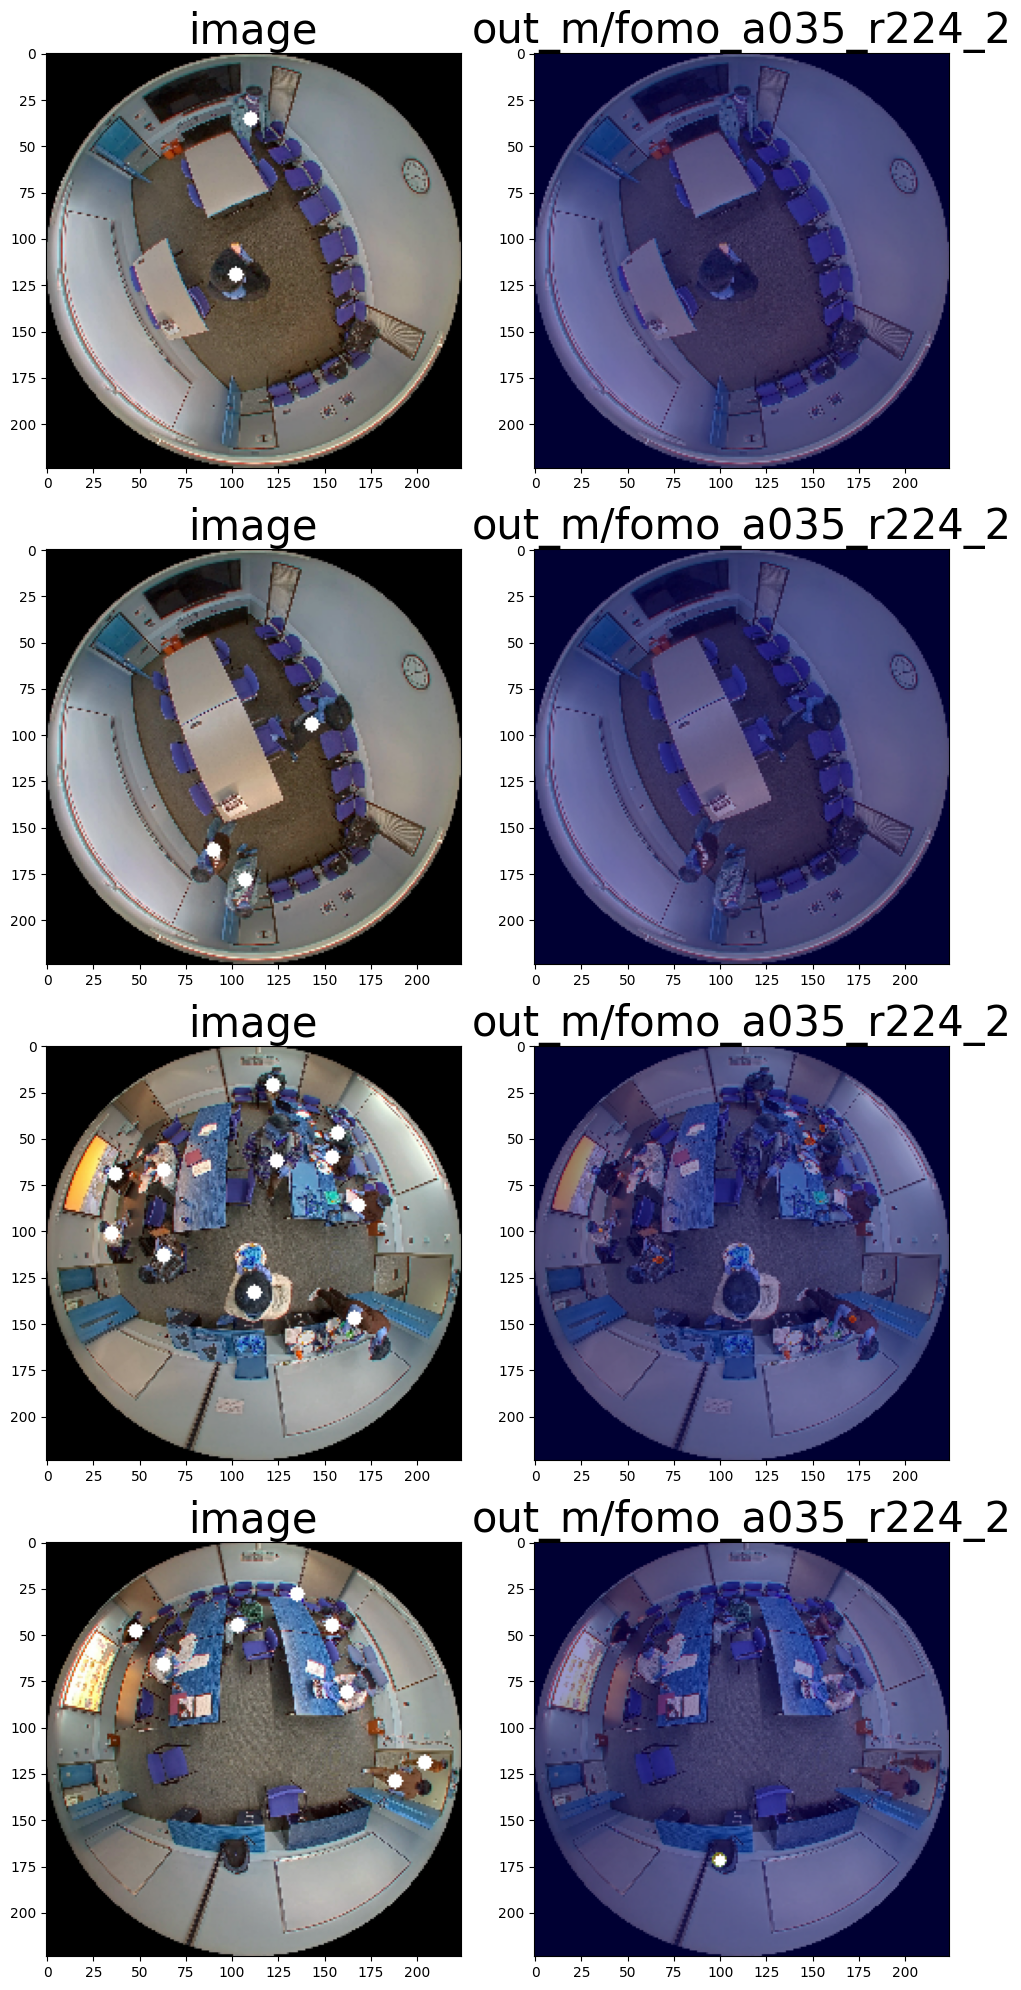

96
out_m/fomo_a035_r96_3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
out_m/fomo_a035_r96_3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
out_m/fomo_a035_r96_3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
out_m/fomo_a035_r96_3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


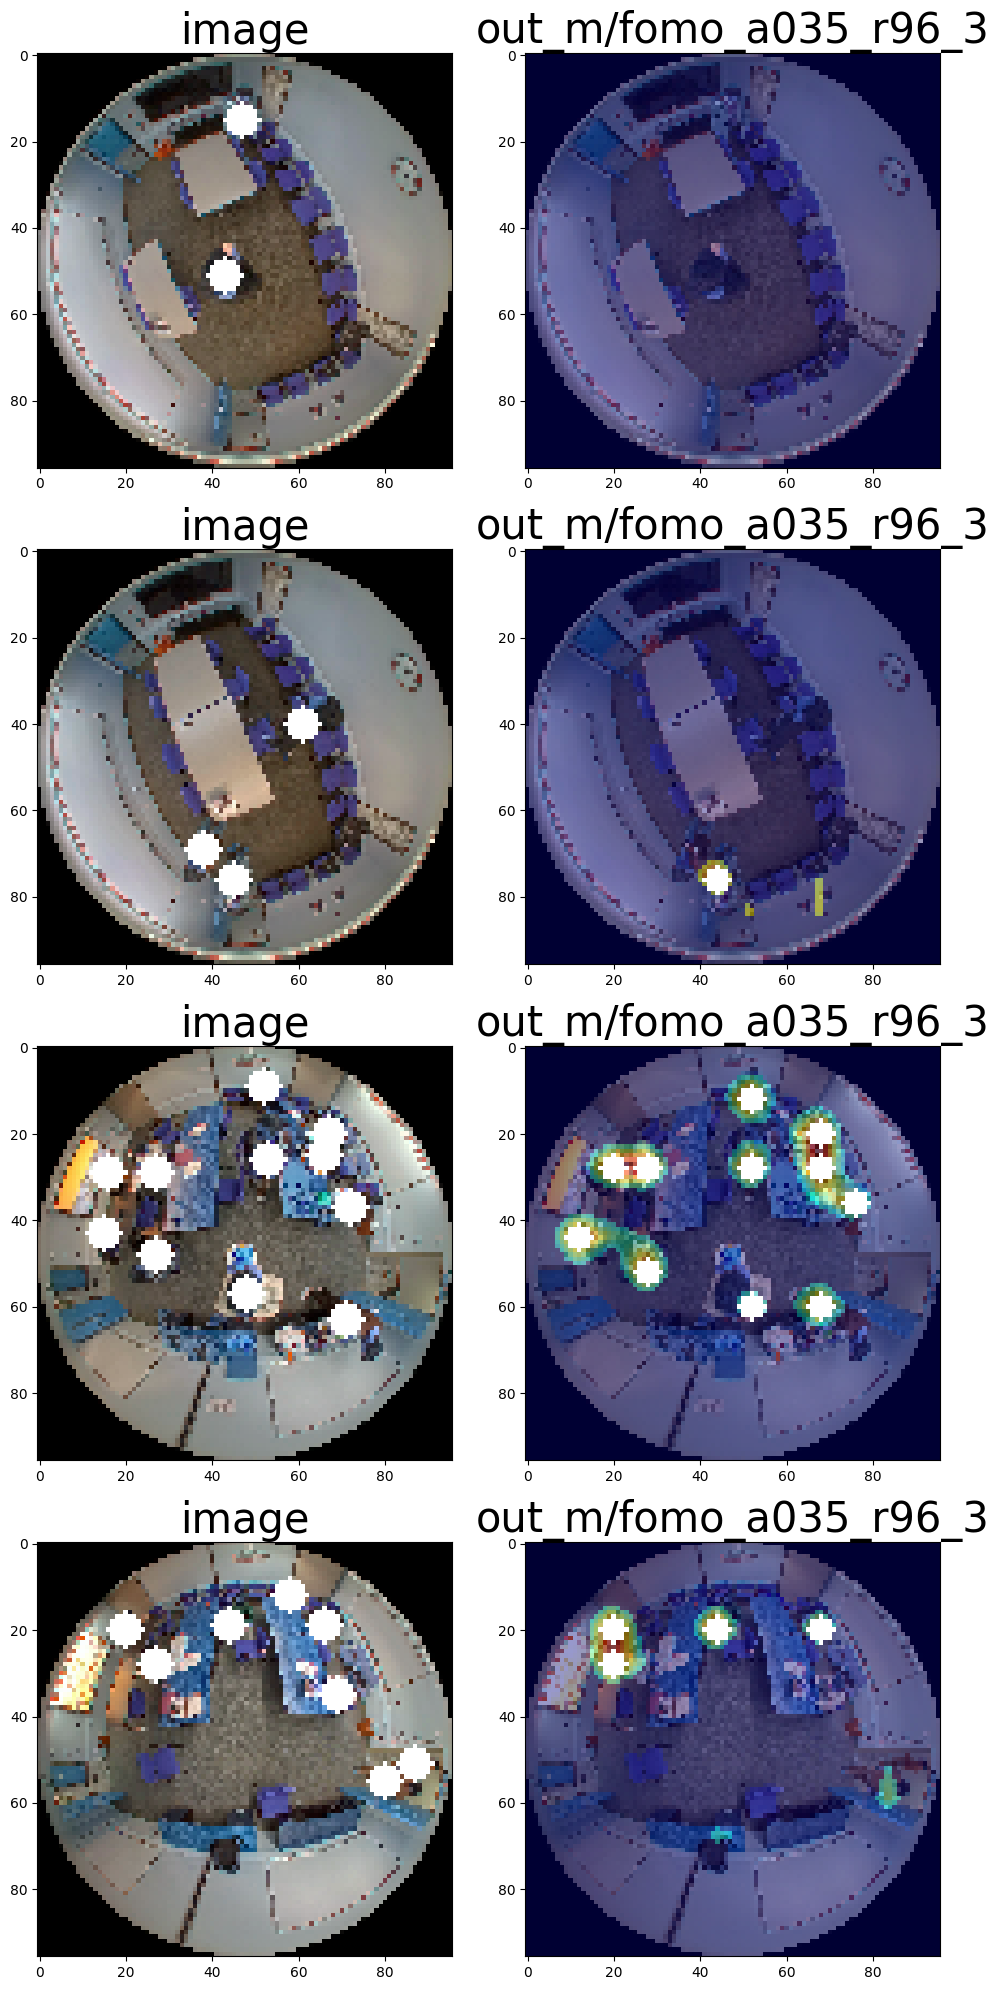

In [19]:
import re

images = ["../../dataset/hc/val/images/Meeting1_000201.jpg",
          "../../dataset/hc/val/images/Meeting2_000441.jpg",
          "../../dataset/hc/val/images/Lunch2_001441.jpg",
          "../../dataset/hc/val/images/Lunch3_000521.jpg",
          ]

for model_dir in lijst:
    if "a035" in model_dir:
        out= []
        out_names = []
        res = int(re.search("r\d*", model_dir).group(0).replace("r", ""))
        print(res)
        model = tf.keras.models.load_model(f"{model_dir}.keras", compile=True, custom_objects={'weighted_xent': ml.construct_weighted_xent_fn((1, res // 8, res // 8, 2), object_weight=100)})
        for img_path in images:
            arr, img = get_img_array(img_path, res)
            out.append(np.uint8(get_image_with_fomo_centers(img_path, img_path.replace("images" , "labels").replace(".jpg", ".txt"), res)))
            out_names.append("image")
            print(model_dir)
            out.append(np.uint8(plot_fomo_output(arr, model.predict(arr), show=False, show_centers=True, threshold=0.5)))
            out_names.append(model_dir)
        show_image_list(out, out_names, figsize=(10, 20), grid=False)

### Convert and quantize the models to tflite.

models are:
- fomo_a035_r96_3
- fomo_a035_r128_2

In [ ]:
def get_dataset(data):
    dl_loaders =[]
    datasets = []
    ds = []
    for i in [96, 128, 224]:
        dl_loaders.append(dl("RGB", "fomo-obj", i))
        dataset, c = dl_loaders[-1].create_dataset_obj(data)
        datasets.append(dataset)
        ds.append((datasets[-1]         
                .map(lambda f, c: dl_loaders[-1].get_sample_fomo(f, c, train=False), 
                    num_parallel_calls=tf.data.AUTOTUNE)
                .batch(35)                          
                .prefetch(tf.data.AUTOTUNE)))
        
    return ds

ds = get_dataset("test")

In [25]:
def to_cpp(tflite_model, tflite_filename, define_name):
    cpp_filename = tflite_filename.replace('.tflite', '.cpp')
    with open(cpp_filename, "w") as f:
        var_name = tflite_filename.replace(".", "_")  # Generate a variable name from the file
        f.write('#include "model.h"\n\n')
        f.write(f'#ifdef {define_name}\n\n')
        f.write("const unsigned char model_data[] = {")

        for i, b in enumerate(tflite_model):
            if i % 12 == 0:  # Break line every 12 bytes like xxd
                f.write("\n    ")
            f.write(f"0x{b:02x}, ")

        f.write("\n};\n")
        f.write(f"const unsigned int model_data_len = {len(tflite_model)};\n")
        f.write(f"#endif    //{define_name}\n")

In [26]:
def representative_dataset():
  for data in ds[1]:
    yield {
      "input_layer_1": data[0]
    }
tf_model = tf.keras.models.load_model("out_m/fomo_a035_r128_2.keras", compile=True, custom_objects={'weighted_xent': ml.construct_weighted_xent_fn((1, 96 // 8, 96 // 8, 2), object_weight=100)})
# tf_model.summary()

#converion for fully int8 quantifier
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

tflite_filename = 'tflite_models/fomo_r128_a035_int8.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_quant_model)

to_cpp(tflite_quant_model, tflite_filename, "FOMO_R128_A035_INT8")

INFO:tensorflow:Assets written to: C:\Users\XANDER~1\AppData\Local\Temp\tmp7kj02fvv\assets


INFO:tensorflow:Assets written to: C:\Users\XANDER~1\AppData\Local\Temp\tmp7kj02fvv\assets


Saved artifact at 'C:\Users\XANDER~1\AppData\Local\Temp\tmp7kj02fvv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 16, 16, 2), dtype=tf.float32, name=None)
Captures:
  2582086738416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582244698848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582244701136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582244696384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582244691808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582244698320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582244692688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582244692864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582244695856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582244698496: TensorSpec(shape=(), dtype=tf.resource, name=N

c:\Users\Xander Verberckt\Documents\person-counting-lc-hw\.venv\lib\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\Xander Verberckt\Documents\person-counting-lc-hw\.venv\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [27]:
def representative_dataset():
  for data in ds[0]:
    yield {
      "input_layer": data[0]
    }
tf_model = tf.keras.models.load_model("out_m/fomo_a035_r96_3.keras", compile=True, custom_objects={'weighted_xent': ml.construct_weighted_xent_fn((1, 96 // 8, 96 // 8, 2), object_weight=100)})
# tf_model.summary()

#converion for fully int8 quantifier
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

tflite_filename = 'tflite_models/fomo_r96_a035_int8.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_quant_model)

to_cpp(tflite_quant_model, tflite_filename, "FOMO_R96_A035_INT8")

INFO:tensorflow:Assets written to: C:\Users\XANDER~1\AppData\Local\Temp\tmpj3ohqn1z\assets


INFO:tensorflow:Assets written to: C:\Users\XANDER~1\AppData\Local\Temp\tmpj3ohqn1z\assets


Saved artifact at 'C:\Users\XANDER~1\AppData\Local\Temp\tmpj3ohqn1z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 12, 12, 2), dtype=tf.float32, name=None)
Captures:
  2582171937152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2581969923312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2581969917328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2581969920848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2581969916448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2581969912048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2581969922432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582327485616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2581969912928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582327482448: TensorSpec(shape=(), dtype=tf.resource, name=None)

c:\Users\Xander Verberckt\Documents\person-counting-lc-hw\.venv\lib\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\Xander Verberckt\Documents\person-counting-lc-hw\.venv\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


### Check accuracy after quantization

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf

def evaluate_mae(model_path, image_paths, count_csv_path, res, get_sample_fn, threshold=0.5):
    # Load ground truth counts
    gt_df = pd.read_csv(count_csv_path)
    gt_dict = dict(zip(gt_df['filename'], gt_df['count']))

    abs_errors = []

    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    for img_path in image_paths:
        filename = os.path.basename(img_path)
        gt_count = gt_dict.get(filename, None)

        if gt_count is None:
            print(f"Warning: No ground truth for {filename}")
            continue

        # Preprocess image
        image_tensor = get_sample_fn(img_path, res)
        input_scale, input_zero_point = input_details[0]['quantization']
        image_tensor_quantized = (image_tensor / input_scale + input_zero_point).astype(np.int8)

        # Model prediction
        interpreter.set_tensor(input_details[0]['index'], image_tensor_quantized)

        interpreter.invoke()

        preds_q = interpreter.get_tensor(output_details[0]['index'])

        output_scale, output_zero_point = output_details[0]['quantization']
        preds = (preds_q.astype(np.float32) - output_zero_point) * output_scale

        # Count detections (FOMO outputs heatmap: count = number of hotspots)
        if preds.shape[-1] == 2:                       # (1,H,W,2)
            heatmap = preds[0, :, :, 0]
        else:                                          # (1,2,H,W)
            heatmap = preds[0, 0, :, :]
        pred_count = np.sum(heatmap > threshold)  

        abs_errors.append(abs(gt_count - pred_count))

    mae = np.mean(abs_errors)
    print(f"MAE: {mae:.4f}")
    return mae

In [29]:
def get_sample(path, res):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, (res, res))
    image = tf.cast(image, tf.float32) / 255.0

    image = tf.expand_dims(image, axis=0)

    return image.numpy()

In [30]:
import os
import re

outputs = dict()

tflites = []

for i in os.listdir("tflite_models"):
    if ".tflite" in i:
        tflites.append(f"tflite_models/{i}")

IMG_PATH = "../../dataset/hc/val/images"
CSV_PATH = "../../dataset/hc/val/count.csv"

for i in tflites:
    print(i)
    res = int(re.search("_r\d*", i).group(0).replace("_r", ""))

    image_paths = list(map(lambda x: os.path.join(IMG_PATH, x), os.listdir(IMG_PATH)))
    mae = evaluate_mae(i, image_paths, CSV_PATH, res=res, get_sample_fn=get_sample, threshold=0.5)

    outputs[i] = mae

tflite_models/fomo_r128_a035_int8.tflite


c:\Users\Xander Verberckt\Documents\person-counting-lc-hw\.venv\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


MAE: 3.3398
tflite_models/fomo_r96_a035_int8.tflite


c:\Users\Xander Verberckt\Documents\person-counting-lc-hw\.venv\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


MAE: 2.3689


In [31]:
outputs

{'tflite_models/fomo_r128_a035_int8.tflite': np.float64(3.3398058252427183),
 'tflite_models/fomo_r96_a035_int8.tflite': np.float64(2.3689320388349513)}